# Case Study of Aral Sea

In [52]:
from IPython.display import display_html

# Define the URLs
url1 = "https://eoimages.gsfc.nasa.gov/images/imagerecords/84000/84437/aralsea_tmo_2000238.jpg"
url2 = "https://eoimages.gsfc.nasa.gov/images/imagerecords/84000/84437/aralsea_tmo_2014231.jpg"

# Display images side by side with dates and a gap
display_html(f'''
<div style="display: flex;">
    <div style="position: relative; width: 50%; margin-right: 20px;">
        <img src="{url1}" style="width: 100%;">
        <div style="position: absolute; top: 10px; left: 10px; background: rgba(255, 255, 255, 0.7); padding: 5px; font-weight: bold;">2000</div>
    </div>
    <div style="position: relative; width: 50%;">
        <img src="{url2}" style="width: 100%;">
        <div style="position: absolute; top: 10px; left: 10px; background: rgba(255, 255, 255, 0.7); padding: 5px; font-weight: bold;">2014</div>
    </div>
</div>
''', raw=True)


2000 
 
 
 
 2014

In [ ]:
!pip install geemap

In [ ]:
!pip install earthengine-api

In [ ]:
!pip install geemap folium

In [ ]:
!pip install folium

# Importing necessary Libraries

In [6]:
import geemap

import ee

import matplotlib.pyplot as plt

import pandas as pd

import subprocess

import json

import seaborn as sns

import matplotlib.image as mpimg

import folium

import geopandas as gpd

import requests

from folium.plugins import Draw

from IPython.display import display

from ipywidgets import widgets

from ipyleaflet import Map, DrawControl

# Authenticate and initialize Earth Engine

In [ ]:
# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='projectnishu')

# Area of Interest

In [31]:
# Load Global Surface Water Data

global_surface_water = ee.Image("JRC/GSW1_4/GlobalSurfaceWater")
occurrence = global_surface_water.select('occurrence')

# Visualization Parameters

visParams = {
    'min': 0,
    'max': 100,
    'palette': ['red', 'blue']
}

# Create the map object

print("Select Area of Interest (AOI) using 'Draw a Rectangle' tool")
center = [45.1952203354707, 58.613519969104985]
zoom = 6
width = '70%'

# Use geemap.Map for folium integration

Map = geemap.Map(center=center, zoom=zoom)
Map.layout.width = width

# Add the Global Surface Water layer

Map.addLayer(occurrence, visParams, "Water Occurrence")

# Add Draw control to the map using geemap's built-in draw control
draw_control = Map.add_draw_control()

# Display the map
display(Map)


Select Area of Interest (AOI) using 'Draw a Rectangle' tool


Map(center=[45.1952203354707, 58.613519969104985], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
Map.draw_features
Map.draw_control.data

In [34]:
# Save drawn features to a GeoJSON file

def save_drawn_features(features, filename='aoi_defined.geojson'):
    feature_collection = {
        "type": "FeatureCollection",
        "features": [{
            "type": "Feature",
            "geometry": feature['geometry'],
            "properties": {}
        } for feature in features]
    }

    with open(filename, 'w') as f:
        json.dump(feature_collection, f)
    print(f"Features saved to {filename}")

# Extract coordinates from GeoJSON file

def extract_coordinates(filename='aoi_defined.geojson'):
    with open(filename, 'r') as f:
        data = json.load(f)

    coordinates = []
    for feature in data['features']:
        if feature['geometry']['type'] == 'Polygon':
            coordinates.append(feature['geometry']['coordinates'])

    return coordinates



In [35]:
# Example usage:

save_drawn_features(Map.draw_control.data)
coordinates = extract_coordinates()
print("Coordinates:", coordinates)

Features saved to aoi_defined.geojson
Coordinates: [[[[60.409318, 46.679594], [59.705802, 46.619261], [59.15618, 46.195042], [58.430679, 45.706179], [57.947012, 45.011419], [58.078921, 44.260937], [58.936331, 43.897892], [59.947635, 43.723475], [60.805045, 43.992815], [61.090849, 44.606113], [61.332682, 45.259422], [61.332682, 45.981695], [61.376652, 46.709736], [60.91497, 47.085085], [60.409318, 46.679594]]]]


In [36]:
# Convert 3D coordinates to 2D

coordinates_2d = [coord[0] for coord in coordinates]

# Convert GeoJSON to ee.Geometry

geometry = ee.Geometry.Polygon(coordinates_2d)

# Creating a Map

Map = geemap.Map(center=[45.1952203354707, 58.613519969104985], zoom=6)
Map.layout.width = "70%"
Map.add_basemap("SATELLITE")
Map.addLayer(geometry, {}, "Aral Sea")
Map.addLayerControl()
Map


Map(center=[45.1952203354707, 58.613519969104985], controls=(WidgetControl(options=['position', 'transparent_b…

# Download the Data

To map the surface water we will download the “global surface water data” from google earth engine catalogue.

In [37]:
image_collection = ee.ImageCollection("JRC/GSW1_4/YearlyHistory")\
.filter(ee.Filter.bounds(geometry))

In [38]:
def mask_surface_water(image):
    '''set the pixel value to 1 wherever water is found and rest will be 0'''
    new_image = image.eq(2).Or(image.eq(3))
    return new_image.copyProperties(image, image.propertyNames())

In [39]:
## mask the area which are not surface water
masked_image_collection = image_collection.map(mask_surface_water)

# Visualize the results on interactive map

In [40]:
## Choose the first image of the year 2000 for visualizing the results
image_2000 = masked_image_collection.filter(ee.Filter.eq('year', 2000)).first()
water_image = image_2000.selfMask()

# Create a map with specified parameters
Map = geemap.Map(width="70%", center=[45.1952203354707, 58.613519969104985], zoom=5)

# Add water image layer to the map
visParams = {'palette': ['blue']}
Map.addLayer(water_image.clip(geometry), visParams)

# Center the map on the specified geometry
Map.centerObject(geometry, zoom=8)

# Display the map
Map


Map(center=[45.2285317848492, 59.82932020338314], controls=(WidgetControl(options=['position', 'transparent_bg…

# Calculate the total surface water area

Mapping this function to calculate the area in each image:

In [41]:
def getWaterSurfaceArea(image):

    areaImage = image.multiply(ee.Image.pixelArea())
    totalArea = areaImage.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = geometry,
        scale=30,
        maxPixels = 1e10
    )

    totalArea = ee.Number(totalArea.get('waterClass')).divide(1e6).round()

    return image.set('area_km2', totalArea)

In [42]:
## calculate the area of each image
areaImages = masked_image_collection.map(getWaterSurfaceArea)

In [ ]:
#print(areaImages )

# Plot the timeseries

In [43]:
def extract_time_series(image_collection, stat='area_km2'):
    '''
    Extract timeseries values, the area values and corresponding the year
    '''

    image_list = image_collection.getInfo()['features']
    properties = [img['properties'] for img in image_list]

    xs, ys = [], []
    for prop in properties:
        x,y = prop['year'], prop[stat]
        xs.append(x), ys.append(y)

    return xs, ys

Extracting the values from the image collection and remove the invalid data points

In [44]:
## Extract the timeseries data from image collection
xs,ys = extract_time_series(areaImages)
## Converting the data to a dataframe
df = pd.DataFrame(zip(xs,ys), columns=['year','area_km2'])

## Removing the null area values
df = df[df['area_km2']>0]

Plot the timeseries:

In [45]:
def plot_time_series(x,y):
    '''
    Plot the time series given the x - year, y - area for example
    and return a matplotlib figure
    '''

    fig,ax = plt.subplots(figsize=(15,3))
    ax.plot(x,y)
    ax.set_xlabel("Year")
    ax.set_ylabel('Surface Water Area (km2)')
    ax.set_title("Total Surface Water Area")
    ax.set_ylim(0,max(y)*1.3)
    ax.grid(axis = 'x')
    return fig

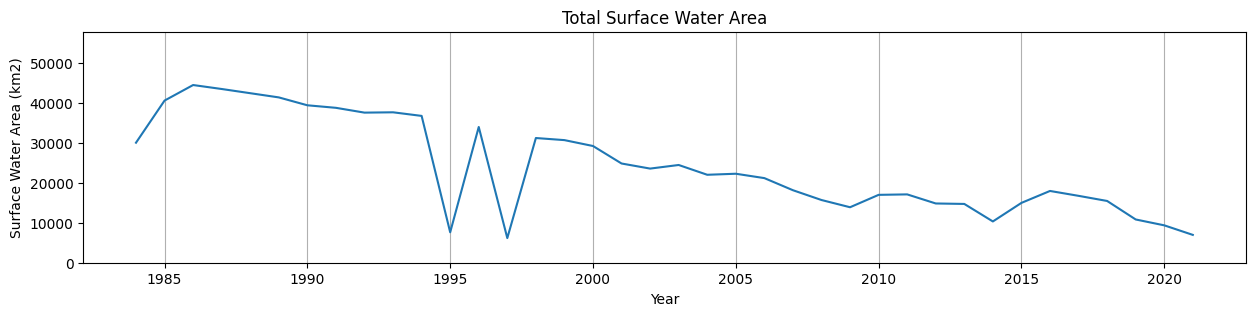

In [46]:
## plotting
fig = plot_time_series(df['year'],df['area_km2'])

Export the plot as image:

In [47]:
fig.savefig('water_surface_area.png', bbox_inches='tight')

Display the image

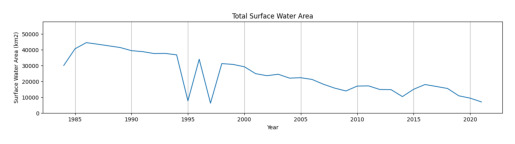

In [48]:

# Load the saved image
saved_image_path = 'water_surface_area.png'
saved_image = mpimg.imread(saved_image_path)

# Display the saved image
plt.imshow(saved_image)
plt.axis('off')  # Turn off axis
plt.show()


# Create an animation and export as GIF

In [49]:
## Remove images with 0 area if any
image_collection = areaImages.filter(ee.Filter.gt('area_km2',0))

## Visualization parameters
visParams = {
    'bands': 'waterClass',
    'palette': ['blue']
}

## Create the image visuals
images = image_collection.map(lambda image: image.visualize(min=0, max=1, palette=['black','blue']).selfMask())

## Define GIF visualization parameters.
gifParams = {
  'region': geometry,
  'dimensions': 600,
  'framesPerSecond': 1
}

## Download the gif
url = images.getVideoThumbURL(gifParams)
subprocess.run(["wget", url, "-O", "surface_water.gif"])

CompletedProcess(args=['wget', 'https://earthengine.googleapis.com/v1/projects/projectnishu/videoThumbnails/9de47ee1397d3f361a3fd76777f2c588-a8161665217af92e80b63e18d3007d61:getPixels', '-O', 'surface_water.gif'], returncode=0)

Display GIF with Time period

In [50]:
text_sequence=[f"Year: {year}" for year in df.year]
new_file_name = "new_surface_water.gif"

geemap.add_text_to_gif(
    "surface_water.gif",
    new_file_name,
    xy=("3%", "5%"),
    text_sequence=text_sequence,
    font_size=30,
    font_color="#ffffff",
    duration=1000 ## in milisecond
)

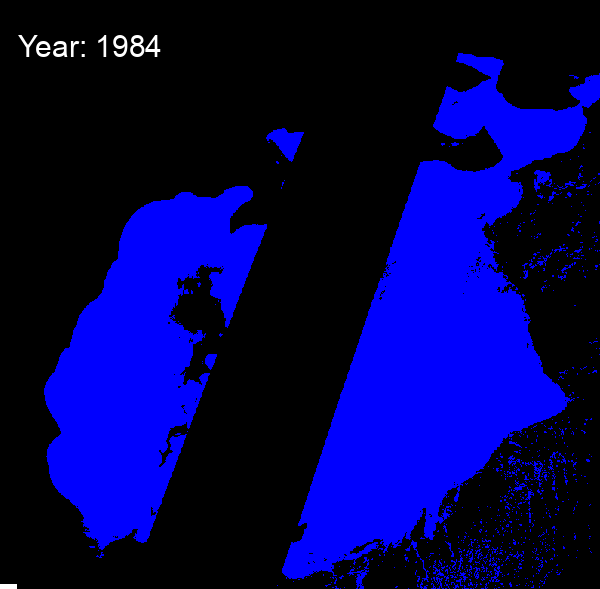

In [51]:
from IPython.display import Image

# Adjust the size of the displayed GIF
Image(filename='new_surface_water.gif', width=800, height=800)